In [1]:
import os
import sys
import cv2
import torch
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt

sys.path.append('/home/hyunjoon/github/tracking-pytorch/')

In [2]:
from pysot.config import cfg
from pysot.models.model_builder import ModelBuilder
from pysot.tracker.tracker_builder import build_tracker
from pysot.utils.bbox import get_axis_aligned_bbox, IoU
from pysot.utils.model_load import load_pretrain
from toolkit.datasets import DatasetFactory

In [3]:
torch.set_num_threads(1)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
# fn_config = 'experiments/baseline/config.yaml'
# snapshot = 'experiments/baseline/snapshot/checkpoint_e99.pth'
fn_config = '/home/hyunjoon/github/tracking-pytorch/experiments/siamcar_mobilenetv2_2gpu/config.yaml'
snapshot = '/home/hyunjoon/github/tracking-pytorch/experiments/siamcar_mobilenetv2_2gpu/snapshot/checkpoint_e20.pth'

In [5]:
cfg.merge_from_file(fn_config)
# cfg.TRACK.LR = 0.1
# cfg.TRACK.WINDOW_INFLUENCE = 0.42

# create model
model = ModelBuilder()

# load model
model = load_pretrain(model, snapshot).cuda().eval()

# build tracker
tracker = build_tracker(model)

In [6]:
tracker.anchors_cwh.shape

(4, 25, 25)

In [7]:
# test image sequence
test_name = 'basketball'

# path_seq = '~/dataset_jinwook/got-10k/val/GOT-10k_Val_000001'
# fn_gt = '~/dataset_jinwook/got-10k/val/GOT-10k_Val_000001/groundtruth.txt'
path_seq = '/home/hyunjoon/dataset_jinwook/vot2018/{}/'.format(test_name)
fn_gt = '/home/hyunjoon/dataset_jinwook/vot2018/{}/groundtruth.txt'.format(test_name)

path_seq = os.path.expanduser(path_seq)
fn_gt = os.path.expanduser(fn_gt)

gt_seq = open(fn_gt, 'r').read().splitlines()
gt_seq = [np.fromstring(l, sep=',') for l in gt_seq]
gt_seq = np.stack(gt_seq, axis=0)

if gt_seq.shape[1] == 8:
    x0 = np.min(gt_seq[:, 0::2], axis=-1)
    y0 = np.min(gt_seq[:, 1::2], axis=-1)
    x1 = np.max(gt_seq[:, 0::2], axis=-1)
    y1 = np.max(gt_seq[:, 1::2], axis=-1)
    
    gt_seq = np.stack([x0, y0, x1-x0, y1-y0], axis=-1)

files_seq = [os.path.join(path_seq, '{:08d}.jpg'.format(i)) for i in range(1, len(gt_seq)+1)]

In [8]:
def _iou(lhs, rhs):
    d = np.minimum(lhs[2:]+lhs[:2], rhs[2:]+rhs[:2]) - np.maximum(lhs[:2], rhs[:2])
    d = np.maximum(d, 0.0)
    I = d[0] * d[1]
    A = lhs[2]*lhs[3] + rhs[2]*rhs[3]
    return I / (A - I)

In [27]:
img = cv2.imread(files_seq[0])
tracker.init(img, gt_seq[0])

if not os.path.exists('./result_images/{}'.format(test_name)):
    os.makedirs('./result_images/{}'.format(test_name))

plt.figure(figsize=(12,12))

ft0 = None # template
ft1 = None
ix0 = -1
iy0 = -1
att_k = None

print('Tracking started, total {} frames.'.format(len(files_seq)))
for ii, fn in enumerate(files_seq[1:], 1):
    t_img = cv2.imread(fn)
    res = tracker.track(t_img)
    
    rbb = np.array(res['bbox'])
    best_idx = res['best_idx']
#     best_score = res['score'][best_idx]
#     print(best_score)

#     output = res['output']
    gt_bb = gt_seq[ii]
    iou = _iou(rbb, gt_bb)
   
#     if ii > 10:
#         break;
    
    if iou < 0.1:
        print('Miss at frame {}'.format(ii))
        break

#     plt.imshow(t_img[:, :, ::-1])
#     rect = plt.Rectangle((rbb[0], rbb[1]),
#                          rbb[2],
#                          rbb[3], fill=False,
#                          edgecolor=[1, 0, 0], linewidth=3.5)
#     plt.gca().add_patch(rect)
    
#     gtbb = gt_seq[ii]
#     rect = plt.Rectangle((gtbb[0], gtbb[1]),
#                          gtbb[2],
#                          gtbb[3], fill=False,
#                          edgecolor=[0, 1, 0], linewidth=2.5)
#     plt.gca().add_patch(rect)
#     plt.savefig('./result_images/{}/res_{:04d}.png'.format(test_name, ii))
#     plt.clf()

Tracking started, total 725 frames.
Miss at frame 64


<Figure size 864x864 with 0 Axes>

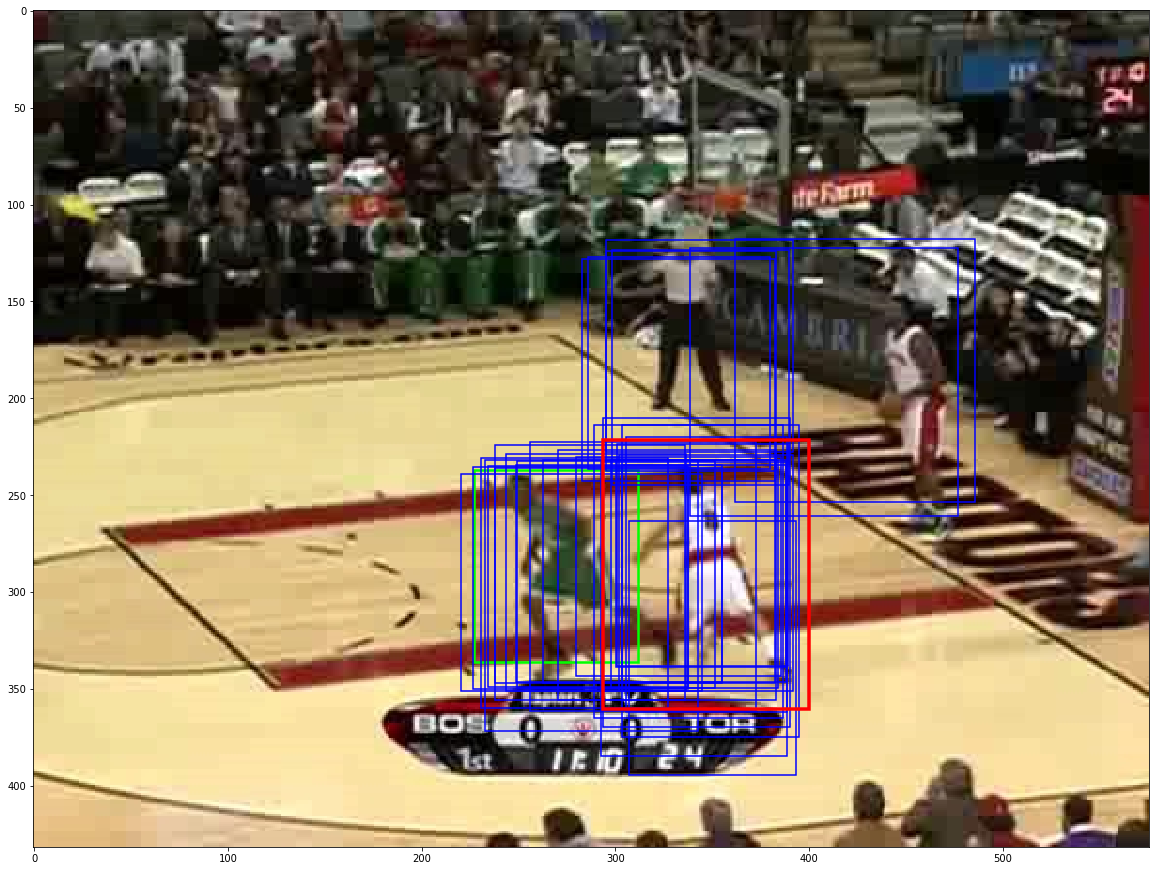

In [28]:
rbb = res['bbox']
plt.figure(figsize=(20,20))
plt.imshow(t_img[:, :, ::-1])

gtbb = gt_seq[ii]
rect = plt.Rectangle((gtbb[0], gtbb[1]),
                     gtbb[2],
                     gtbb[3], fill=False,
                     edgecolor=[0, 1, 0], linewidth=2.5)
plt.gca().add_patch(rect)

for pbb in res['pred_bbox']:
    rect = plt.Rectangle((pbb[0], pbb[1]),
                         pbb[2],
                         pbb[3], fill=False,
                         edgecolor=[0, 0, 1], linewidth=1.5)
    plt.gca().add_patch(rect)
    
rect = plt.Rectangle((rbb[0], rbb[1]),
                     rbb[2],
                     rbb[3], fill=False,
                     edgecolor=[1, 0, 0], linewidth=3.5)
plt.gca().add_patch(rect)

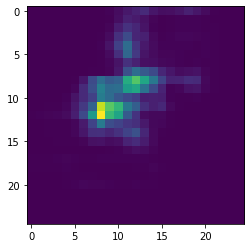

In [29]:
plt.imshow(res['ctr_rpn'].reshape((25, 25)))

In [30]:
np.max(res['ctr_rpn'])

0.2328523

In [31]:
res['pred_bbox']

array([[238.06006 , 236.05533 , 116.92527 , 110.65506 ],
       [248.77443 , 234.50784 , 106.32244 , 111.94475 ],
       [305.3337  , 219.91084 ,  83.09432 , 142.14624 ],
       [262.5961  , 231.62927 , 119.85131 , 115.14815 ],
       [297.83453 , 231.60556 ,  86.03858 , 117.90038 ],
       [243.55418 , 228.99014 ,  93.05935 , 122.28911 ],
       [289.17096 , 213.57475 ,  97.37164 , 151.48868 ],
       [279.77713 , 230.21843 , 105.77628 , 113.061874],
       [300.5599  , 223.48343 ,  88.487045, 114.68635 ],
       [270.54733 , 226.86415 , 112.51624 , 129.03265 ],
       [295.23364 , 123.99226 ,  87.73575 , 113.47429 ],
       [234.33887 , 235.05841 , 102.90596 , 113.98919 ],
       [255.70847 , 222.68071 , 116.66943 , 138.74214 ],
       [303.57602 , 213.65694 ,  90.95075 , 160.91437 ],
       [293.5058  , 210.15654 ,  96.39652 , 159.69492 ],
       [307.255   , 263.55487 ,  85.85814 , 130.68619 ],
       [249.39496 , 232.57916 , 102.01128 , 116.99433 ],
       [237.65926 , 224.14438 ,

In [32]:
np.around(res['ctr_rcnn'], 3)

array([0.086, 0.109, 0.089, 0.072, 0.073, 0.076, 0.049, 0.037, 0.042,
       0.073, 0.058, 0.049, 0.049, 0.049, 0.044, 0.018, 0.039, 0.015,
       0.016, 0.019, 0.02 , 0.019, 0.034, 0.013, 0.021, 0.016, 0.028,
       0.009, 0.022, 0.007, 0.006, 0.018], dtype=float32)

In [33]:
np.around(res['cls_rcnn'], 3)

array([0.209, 0.376, 0.256, 0.229, 0.208, 0.356, 0.024, 0.11 , 0.127,
       0.32 , 0.287, 0.235, 0.123, 0.062, 0.058, 0.033, 0.133, 0.006,
       0.04 , 0.032, 0.069, 0.069, 0.195, 0.052, 0.082, 0.057, 0.165,
       0.02 , 0.105, 0.006, 0.005, 0.069], dtype=float32)

In [34]:
np.around(res['pscore'], 3)

array([0.399, 0.419, 0.431, 0.423, 0.427, 0.394, 0.419, 0.419, 0.416,
       0.43 , 0.227, 0.379, 0.412, 0.419, 0.419, 0.404, 0.397, 0.373,
       0.368, 0.419, 0.366, 0.418, 0.231, 0.418, 0.198, 0.376, 0.223,
       0.416, 0.231, 0.202, 0.17 , 0.361], dtype=float32)

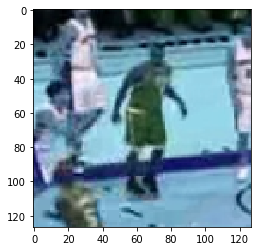

In [35]:
plt.imshow(tracker.img_z)

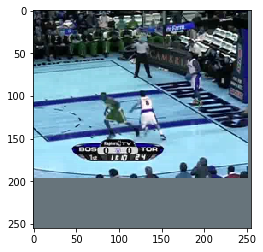

In [18]:
plt.imshow(tracker.img_x)

In [41]:
A = torch.zeros(3, 5)
B = torch.empty_like(A).normal_(0, 0.333)
C = torch.ones_like(A) * 2.0
C.pow_(B)

tensor([[0.7833, 1.1970, 0.8973, 0.8379, 1.0159],
        [1.0027, 1.0735, 0.8876, 1.3239, 0.9194],
        [0.8547, 0.9036, 0.6114, 0.7939, 0.6056]])

In [43]:
B

tensor([[-0.3523,  0.2594, -0.1564, -0.2552,  0.0228],
        [ 0.0039,  0.1023, -0.1720,  0.4048, -0.1212],
        [-0.2266, -0.1463, -0.7099, -0.3330, -0.7237]])